# SSL on STL-10: Experiments Report (SimCLR)

This notebook is **analysis-only**: it does **not** re-train models.
It reads artifacts/logs produced by `python -m src.train_ssl --config ...` and builds a clean report:
- runs table (config ↔ version ↔ checkpoints)
- loss curves (step / epoch)
- quick sanity checks and next steps

> Project root expected: `D:/ML/SSL` with folders `artifacts/`, `configs/`, `lightning_logs/`, `src/`, `notebooks/`.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent 
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
FIG_DIR = ARTIFACTS_DIR / "figures"
LIGHTNING_LOGS = PROJECT_ROOT / "lightning_logs"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("METRICS_DIR:", METRICS_DIR)
print("LIGHTNING_LOGS:", LIGHTNING_LOGS)

PROJECT_ROOT: D:\ML\SSL
METRICS_DIR: D:\ML\SSL\artifacts\metrics
LIGHTNING_LOGS: D:\ML\SSL\lightning_logs


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.seed import set_seed
set_seed(42)

## 1) Load run index & summary

Expected files (generated by your scripts):
- `artifacts/metrics/runs_index.csv`
- `artifacts/metrics/summary.csv`

If they don't exist yet — you can generate them by running your collector script
(e.g. `python -m src.utils.collect_metrics`), then re-run this notebook.


In [3]:
runs_path = METRICS_DIR / "runs_index.csv"
summary_path = METRICS_DIR / "summary.csv"

runs_df = pd.read_csv(runs_path) if runs_path.exists() else pd.DataFrame()
summary_df = pd.read_csv(summary_path) if summary_path.exists() else pd.DataFrame()

display(runs_df.head(20))

,run_id,method,timestamp,version_dir,metrics_csv
0,simclr_version_0,simclr,2025-12-28T20:39:25,artifacts/logs/simclr/version_0,artifacts/logs/simclr/version_0/metrics.csv


In [4]:
display(summary_df.head(50))

,run_id,method,timestamp,version_dir,metrics_csv,n_rows,last_epoch,train_loss_epoch,train_loss_step
0,simclr_version_0,simclr,2025-12-28T20:39:25,artifacts/logs/simclr/version_0,artifacts/logs/simclr/version_0/metrics.csv,200,4,2.268588,2.391472


## 2) Pick a run to plot

We try, in order:
1) `runs_index.csv` last row
2) latest `lightning_logs/version_*`


In [14]:
assert not runs_df.empty, "runs_index.csv is empty — run collect_metrics first."

run = runs_df.iloc[-1].to_dict()  # latest run
run_id = run["run_id"]
method = run["method"]
version_dir = PROJECT_ROOT / Path(run["version_dir"])
metrics_csv = PROJECT_ROOT / Path(run["metrics_csv"])

title_suffix = f"{method} — {run_id}"

print("Selected run:")
print(" run_id     :", run_id)
print(" method     :", method)
print(" version_dir:", version_dir)
print(" metrics_csv:", metrics_csv)

assert metrics_csv.exists(), f"metrics.csv not found: {metrics_csv}"

Selected run:
 run_id     : simclr_version_0
 method     : simclr
 version_dir: D:\ML\SSL\artifacts\logs\simclr\version_0
 metrics_csv: D:\ML\SSL\artifacts\logs\simclr\version_0\metrics.csv


In [15]:
m = pd.read_csv(metrics_csv)
print("metrics.csv shape:", m.shape)
print("columns:", list(m.columns))
m.head()

metrics.csv shape: (200, 4)
columns: ['epoch', 'step', 'train_loss_epoch', 'train_loss_step']


,epoch,step,train_loss_epoch,train_loss_step
0,0,19,NaN,4.673576
1,0,39,NaN,4.259895
2,0,59,NaN,4.085144
3,0,79,NaN,4.115761
4,0,99,NaN,3.787979


## 3) Loss curves

Lightning typically logs:
- `train_loss_step` with `step`
- `train_loss_epoch` with `epoch`

We plot both if present.


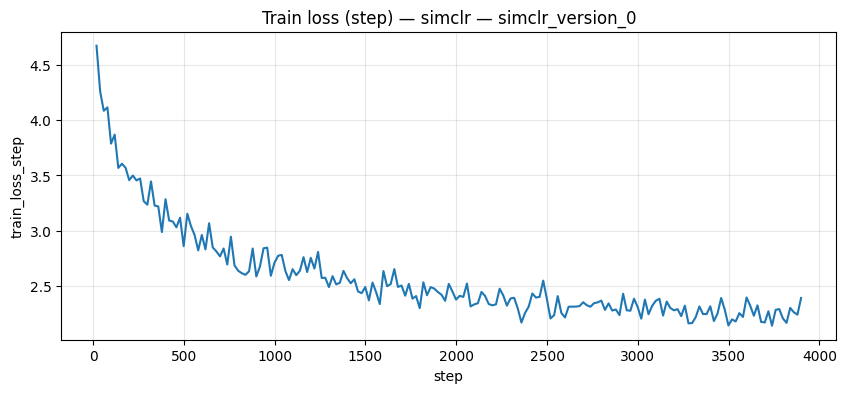

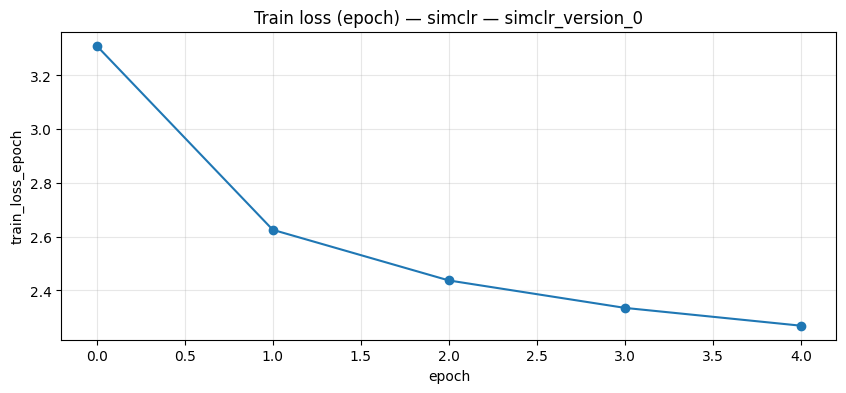

In [16]:
def plot_series(df: pd.DataFrame, x: str, y: str, title: str):
    d = df[[x, y]].dropna()
    if d.empty:
        print(f"Skip: no data for {y}")
        return
    plt.figure(figsize=(10, 4))
    plt.plot(d[x].to_numpy(), d[y].to_numpy())
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Step loss ---
if "train_loss_step" in m.columns and "step" in m.columns:
    plot_series(m, "step", "train_loss_step", f"Train loss (step) — {title_suffix}")
else:
    print("No train_loss_step/step columns found")

# --- Epoch loss ---
if "train_loss_epoch" in m.columns:
    epoch_rows = m[["epoch", "train_loss_epoch"]].dropna().copy()
    if epoch_rows.empty:
        print("Skip: no non-NaN train_loss_epoch rows")
    else:
        # make epoch integer for pretty x-axis
        epoch_rows["epoch_int"] = epoch_rows["epoch"].astype(int)
        plt.figure(figsize=(10, 4))
        plt.plot(epoch_rows["epoch_int"].to_numpy(), epoch_rows["train_loss_epoch"].to_numpy(), marker="o")
        plt.title(f"Train loss (epoch) — {title_suffix}")
        plt.xlabel("epoch")
        plt.ylabel("train_loss_epoch")
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("No train_loss_epoch column found")

In [17]:
print("Last step-level logs (train_loss_step):")
if "train_loss_step" in m.columns:
    display(m[["epoch", "step", "train_loss_step"]].dropna().tail(20))
else:
    print("No train_loss_step")

print("\nEpoch-level logs (train_loss_epoch):")
if "train_loss_epoch" in m.columns:
    display(m[["epoch", "step", "train_loss_epoch"]].dropna())
else:
    print("No train_loss_epoch")

Last step-level logs (train_loss_step):


,epoch,step,train_loss_step
179,4,3519,2.198036
180,4,3539,2.179203
181,4,3559,2.254295
182,4,3579,2.219723
183,4,3599,2.396400
184,4,3619,2.321384
185,4,3639,2.230812
186,4,3659,2.324890
187,4,3679,2.175430
188,4,3699,2.169998



Epoch-level logs (train_loss_epoch):


,epoch,step,train_loss_epoch
39,0,780,3.310672
79,1,1561,2.625528
119,2,2342,2.437019
159,3,3123,2.334881
199,4,3904,2.268588


In [18]:
summary = {}

if "train_loss_step" in m.columns:
    step_vals = m["train_loss_step"].dropna()
    if len(step_vals) > 0:
        summary["step_loss_last"] = float(step_vals.iloc[-1])
        summary["step_loss_min"] = float(step_vals.min())

if "train_loss_epoch" in m.columns:
    epoch_vals = m["train_loss_epoch"].dropna()
    if len(epoch_vals) > 0:
        summary["epoch_loss_last"] = float(epoch_vals.iloc[-1])
        summary["epoch_loss_min"] = float(epoch_vals.min())
        summary["epochs_logged"] = int(len(epoch_vals))

pd.DataFrame([summary])

,step_loss_last,step_loss_min,epoch_loss_last,epoch_loss_min,epochs_logged
0,2.391472,2.140652,2.268588,2.268588,5


# Conclusions & Next Steps
## Training sanity check

In this notebook we analyzed the training artifacts of a SimCLR model trained on the STL-10 unlabeled split.

## Key observations:

- Step-level loss shows a clear downward trend
(from ~4.6 at the beginning to ~2.2 by the end of training),
indicating stable contrastive learning dynamics.

- Epoch-level loss is logged once per epoch and also decreases consistently,
reaching ~2.27 by epoch 5.

- No signs of divergence, exploding loss, or numerical instability were observed.

## This confirms that:

- the data pipeline,

- augmentations,

- contrastive loss (NT-Xent), and

- training infrastructure

are all functioning correctly.

⚠️ Note: the current run is intentionally short (5 epochs) and serves as a sanity check,
not a final performance benchmark.

## Limitations of the current experiment

Training was performed for a small number of epochs.

No quantitative evaluation of representations (kNN / linear probe) was performed yet.

Only SimCLR was explored so far (no method comparison).

## What comes next

The next steps focus on evaluating the learned representations, not on re-training:

UMAP visualization of embeddings
Visual inspection of the representation space using labeled STL-10 samples.

Retrieval demo
Nearest-neighbor search in embedding space to demonstrate semantic similarity.

Quantitative evaluation

kNN classification on frozen embeddings

Linear probe evaluation

Method comparison
Extend the pipeline with BYOL and compare results against SimCLR.

## Takeaway

This notebook validates the training stage of the SSL pipeline.
Subsequent notebooks will focus on representation quality and downstream behavior rather than loss curves.